In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import random 

Define the Unet Model 

In [ ]:
class DoubleConv(nn.Module):
    """(卷积 => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        """
        Args:
            n_channels: 输入图像的通道数（RGB为3，灰度图为1）
            n_classes: 输出分割的类别数
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        

        # 编码器（下采样路径）
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # 解码器（上采样路径）
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x, verbose=False):
        if verbose:
            print(f"输入形状: {x.shape}")
    
        # 编码器
        x1 = self.inc(x)
        if verbose:
            print(f"inc 输出 (x1): {x1.shape}")
        
        x2 = self.down1(x1)
        if verbose:
            print(f"down1 输出 (x2): {x2.shape}")
        
        x3 = self.down2(x2)
        if verbose:
            print(f"down2 输出 (x3): {x3.shape}")
        
        x4 = self.down3(x3)
        if verbose:
            print(f"down3 输出 (x4): {x4.shape}")
        
        x5 = self.down4(x4)
        if verbose:
            print(f"down4 输出 (x5): {x5.shape}")

        # 解码器（带跳跃连接）
        x = self.up1(x5)
        if verbose:
            print(f"up1 输出: {x.shape}")
        
        x = torch.cat([x4, x], dim=1)
        if verbose:
            print(f"cat(x4, up1) 后: {x.shape}")
        
        x = self.conv1(x)
        if verbose:
            print(f"conv1 输出: {x.shape}")

        x = self.up2(x)
        if verbose:
            print(f"up2 输出: {x.shape}")
        
        x = torch.cat([x3, x], dim=1)
        if verbose:
            print(f"cat(x3, up2) 后: {x.shape}")
        
        x = self.conv2(x)
        if verbose:
            print(f"conv2 输出: {x.shape}")

        x = self.up3(x)
        if verbose:
            print(f"up3 输出: {x.shape}")
        
        x = torch.cat([x2, x], dim=1)
        if verbose:
            print(f"cat(x2, up3) 后: {x.shape}")
        
        x = self.conv3(x)
        if verbose:
            print(f"conv3 输出: {x.shape}")

        x = self.up4(x)
        if verbose:
            print(f"up4 输出: {x.shape}")
        
        x = torch.cat([x1, x], dim=1)
        if verbose:
            print(f"cat(x1, up4) 后: {x.shape}")
        
        x = self.conv4(x)
        if verbose:
            print(f"conv4 输出: {x.shape}")

        # 输出
        logits = self.outc(x)
        if verbose:
            print(f"最终输出 (logits): {logits.shape}")
            print(f"输出值范围: [{logits.min().item():.4f}, {logits.max().item():.4f}]")
        
        return logits
    # def forward(self, x):
    #     # 编码器
    #     x1 = self.inc(x)
    #     x2 = self.down1(x1)
    #     x3 = self.down2(x2)
    #     x4 = self.down3(x3)
    #     x5 = self.down4(x4)

    #     # 解码器（带跳跃连接）
    #     x = self.up1(x5)
    #     x = torch.cat([x4, x], dim=1)
    #     x = self.conv1(x)

    #     x = self.up2(x)
    #     x = torch.cat([x3, x], dim=1)
    #     x = self.conv2(x)

    #     x = self.up3(x)
    #     x = torch.cat([x2, x], dim=1)
    #     x = self.conv3(x)

    #     x = self.up4(x)
    #     x = torch.cat([x1, x], dim=1)
    #     x = self.conv4(x)

    #     # 输出
    #     logits = self.outc(x)
    #     return logits

    


In [5]:
# 测试：查看模型各层输出信息
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

print("=" * 60)
print("UNet 模型各层输出信息")
print("=" * 60)

with torch.no_grad():
    output = model(input_tensor, verbose=True)

print("=" * 60)
print(f"最终输出形状: {output.shape}")
print(f"最终输出值范围: [{output.min().item():.4f}, {output.max().item():.4f}]")

NameError: name 'model' is not defined

In [ ]:
# Initial the mode 

# 对于 RGB 图像（3通道）进行二分类分割（1个输出通道）
model = UNet(n_channels=3, n_classes=1)

# 或者对于灰度图像（1通道）
# model = UNet(n_channels=1, n_classes=1)

# 如果有多个类别，比如分割成3类
# model = UNet(n_channels=3, n_classes=3)

In [ ]:

# 假设你有一张图像，需要转换为 tensor
# 输入格式: (batch_size, channels, height, width)
# 例如: (1, 3, 256, 256) 表示 1 张 256x256 的 RGB 图像



# 加载图像
# image = Image.open('your_image.jpg').convert('RGB')
# 使用一个虚拟的数据集

# 使用一个虚拟的数据集
train_data = torch.randn(1, 3, 256, 256)
train_label = torch.randn(1, 1, 256, 256)

# 创建数据加载器

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_label),
    batch_size=1, shuffle=True
)

# 这里不要再用 transforms 了，直接当输入即可
input_tensor = train_data  # 形状已经是 (1, 3, 256, 256)

In [ ]:
# 将模型设置为评估模式
model.eval()

# 如果使用 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

# 进行推理（不需要梯度计算）
with torch.no_grad():
    output = model(input_tensor)
    # output 的形状: (batch_size, n_classes, height, width)
    # 例如: (1, 1, 256, 256)
    
# 如果做二分类，可以用 sigmoid 激活
prediction = torch.sigmoid(output)
# 或者转换为二值掩码
mask = (prediction > 0.5).float()

In [ ]:
import torch.optim as optim

# 创建模型
model = UNet(n_channels=3, n_classes=1)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()  # 二分类
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# 训练模式
model.train()

# 训练循环示例
for epoch in range(num_epochs):
    for images, masks in train_loader:  # 用上面定义的 train_loader
        images = images.to(device)
        masks = masks.to(device)
        
        # 前向传播
        outputs = model(images)
        
        # 计算损失
        loss = criterion(outputs, masks)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Forward process

## Import data

In [6]:
import pandas as pd 

train_data = pd.read_csv('trainning_data_merged.csv')

## Add noise 

Randomize 高斯噪音: $G_t$, 重尾因子 $S_{\alpha}$ 以及一个 时间步 $t$

In [7]:

T = 4000
t = random.randint(0, T)

def generate_noises(dim, alpha, size=1):
    """
    dim: 数据的维度 (例如图像的通道*高*宽)
    alpha: 尾部指数 (1 < alpha < 2)
    """
    # 1. 生成标准高斯噪音 (Gaussian Noise)
    # 在 DLPM 中对应 G_t [cite: 108, 559]
    gaussian_noise = np.random.normal(0, 1, (size, dim))
    
    # 2. 生成正稳定分布因子 (Positive Stable Variable A)
    # 对应论文中的 A ~ S_{alpha/2, 1}(0, c_A) [cite: 108, 559]
    # 使用 CMS 采样方法
    def sample_positive_stable(a_val, num_samples):
        # 这里的 a_val 对应论文中的 alpha/2 [cite: 108, 112]
        half_alpha = a_val / 2
        U = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
        W = np.random.exponential(1, num_samples)
        
        # 核心 CMS 公式
        term1 = np.sin(half_alpha * (U + np.pi/2)) / (np.cos(U)**(1/half_alpha))
        term2 = (np.cos(U - half_alpha * (U + np.pi/2)) / W)**((1 - half_alpha) / half_alpha)
        A = (term1 * term2)
        
        # 乘以尺度常数 c_A = cos^{2/alpha}(pi * alpha / 4) [cite: 108, 552]
        c_A = np.cos(np.pi * a_val / 4)**(1 / half_alpha)
        return A * c_A

    A_t = sample_positive_stable(alpha, size)
    
    # 3. 合成 DLPM 特有的重尾噪音
    # epsilon = sqrt(A) * G 
    heavy_tailed_noise = np.sqrt(A_t)[:, np.newaxis] * gaussian_noise
    
    return gaussian_noise, A_t, heavy_tailed_noise

# 示例：alpha=1.7 (论文中常用的值) [cite: 242, 402]
alpha = 1.
g_noise, a_factor, ht_noise = generate_noises(dim=252, alpha = alpha)
# 其中的ht_noise 就是最后我们需要的噪音 


Plot the noise if necessary 

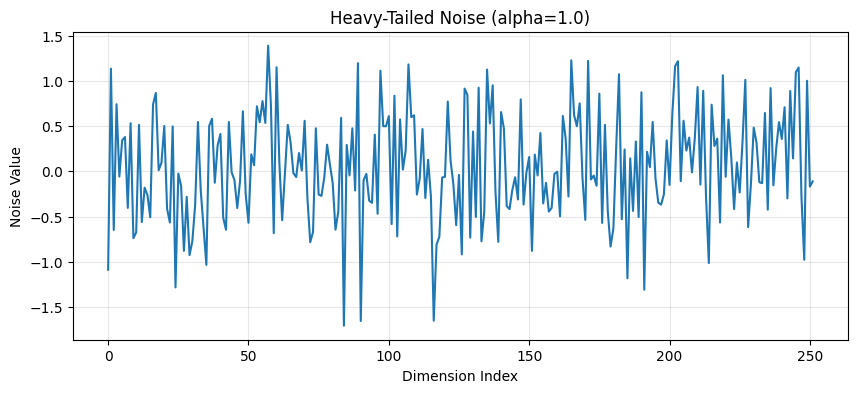

ht_noise 形状: (1, 252)
均值: 0.0504
标准差: 0.6019
最小值: -1.7067
最大值: 1.3874


In [8]:
# plot the noise
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(ht_noise[0])  # 取第一行（因为 size=1）
plt.xlabel('Dimension Index')
plt.ylabel('Noise Value')
plt.title(f'Heavy-Tailed Noise (alpha={alpha})')
plt.grid(True, alpha=0.3)
plt.show()

# 也可以打印一些统计信息
print(f"ht_noise 形状: {ht_noise.shape}")
print(f"均值: {ht_noise.mean():.4f}")
print(f"标准差: {ht_noise.std():.4f}")
print(f"最小值: {ht_noise.min():.4f}")
print(f"最大值: {ht_noise.max():.4f}")

# Training process

## Cosine scheduler (input = T, t, $\alpha$) = (output = $\gamma_{1\rightarrow t}$, $\sigma_{1\rightarrow t}$)

这个里面对应的 T 指的是总的时间步骤，alpha 决定噪声的“重尾”程度。当 $\alpha$ 越小（如 1.5），产生的噪声中偶尔会出现极大的“跳跃”值 9999。 

$t$ 决定了公式里 $\gamma_{1\rightarrow t}$ 和 $\sigma_{1\rightarrow t}$ 到底取数组里的哪一个数

In [ ]:
def get_dlpm_cosine_schedule(T, alpha, s=0.008):
    """
    T: 总时间步 (Total time steps)
    alpha: 尾部指数 (Tail index, 1 < alpha <= 2)
    s: 偏移量，防止 t=0 时噪声过大
    """
    # 1. 定义时间步序列
    steps = np.arange(T + 1)
    
    # 2. 计算累积比例函数 f(t) [余弦曲线核心]
    # 使用余弦平方函数，确保加噪过程平滑
    ft = np.cos(((steps / T) + s) / (1 + s) * (np.pi / 2))**2
    
    # 3. 计算累积噪声控制序列 alpha_bar (在 DLPM 中对应缩放逻辑)
    # alpha_bar 决定了原始信号保留的比例
    alphas_bar = ft / ft[0]
    
    # 4. 根据 alpha_bar 计算 DLPM 特有的调度参数
    # gamma_1_to_t: 位置/衰减系数 (控制原始数据 Y0 保留比例)
    gamma_1_to_t = (alphas_bar)**(1 / alpha)
    
    # sigma_1_to_t: 尺度/噪声系数 (控制注入重尾噪声的强度)
    # 基于尺度保持原则: gamma^alpha + sigma^alpha = 1
    sigma_1_to_t = (1 - alphas_bar)**(1 / alpha)
    
    return gamma_1_to_t[1:], sigma_1_to_t[1:]

# 使用示例
T = 1000
alpha = 1.7
gamma_bar, sigma_bar = get_dlpm_cosine_schedule(T, alpha)
# 这个里面的的下标 对应的是不同的t

Get $Y_t$ with formula: 

$Y_t = \gamma_{1\rightarrow t}Y_0 + \sigma_{1\rightarrow t}\overline{A}_t^{1/2}G_t$ 

In [37]:
def get_Y_t(Y_0, t, gamma_bar, sigma_bar, noise):
    return gamma_bar[t] * Y_0 + sigma_bar[t] * noise

In [ ]:
# get final Y_t

# Y_0 = train_data  => Y_t = get_Y_t(Y_0, t, gamma_bar, sigma_bar,ht_noise)

